In [1]:
import robobo
import pandas as pd
import torch
import time
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
from tqdm import tqdm
import numpy as np
from collections import deque

Hardware Connection not available in python3 :(


In [21]:
class Environment(robobo.SimulationRobobo):
    def __init__(self,
                 number,act_granularity_s,add_noise=True,
                 sim_time_s=np.inf
                 ):
        super().__init__(number=number)
        super().connect('192.168.1.133', 19997)
        self.attempts = 0
        self.add_noise = add_noise
        self.action_space = {0:(25, 25),
                               1:(12.5, 12.5),
                               2:(0, 0),
                               3:(-12.5, -12.5),
                               4:(-25, -25),
                               5:(25, 5),
                               6:(5, 25),
                               7:(20,10),
                               8:(10, 20),
                               9:(5, 5)}
        self.last_state = np.zeros(8)
        self.last_action = np.array([0,0])
        self.sim_time = sim_time_s * 1000.
        self.initiated = False
        self.fps = 1000 / act_granularity_s
        self.act_granularity = act_granularity_s * 1000
    def start_sim(self): return self.play_simulation()
    def end_sim(self): return self.stop_world()
    def pause_sim(self): return self.pause_simulation()
    def reset(self):
        try:
            if self.is_simulation_running():
                self.end_sim()
                self.start_sim()
            else:
                self.start_sim()
            time.sleep(2)
            return self.get_state()
        except:
            print(f"Fail - Attempt {self.attempts}")
            self.attempts += 1
            self.disconnect()
            self.connect('192.168.1.133', 19997)
            self.reset()
    def get_state(self, add_noise=True):
        if self.is_simulation_running():
            #todo do in parent class
            X1 = np.array([[ .2 if not _ else _ for _ in env.read_irs() ]])
            X1 = (X1 - 0.) / (.2 - 0.) 
            X1 = 1 - X1 
            X1[0,:3] = X1[0,:3] * 1.5
            return X1
        else:
            print("failed to read irs")
            self.start_sim()
            return self.get_state()
    def step(self, action, discrete=True):
        if not discrete:
            action = action[0][0] * 100
        else:
            action = np.array(self.action_space[action])
        self.move(action[0]+5, action[1]+5, self.act_granularity)
        new_state = self.get_state()
        penalty = np.exp(new_state.sum()) 
        penalty_prev = np.exp(self.last_state.sum()) 
        #((penalty_prev + penalty)) * (penalty_prev / penalty)
        #reward = action.sum()
        #diff = penalty_prev - penalty_prev
        #reward -= (penalty_prev/penalty) * action.sum().__abs__() - penalty
        #reward = { 0 : 20, 1: 1, 2: 1, 3:1, 4:1 }[a] if penalty==1. else 0
        #reward =  np.maximum(np.array(action).sum(), 0.) - np.abs(action[0] - action[1])*0.5 - 10*penalty - penalty_prev 
        #reward = - 2*(penalty / penalty_prev)*penalty
        reward = - penalty #+np.maximum(np.array(action).sum(), 0.)*0.25
        #if penalty + penalty_prev == 2. and action.sum() == 40:
        #    reward += 5
        #sensors = np.exp(new_state.sum()*1.25) 
        #rot = np.abs(action[0] - action[1])
        #rot_norm = rot / 200
        #if action.sum() < 0:
        #    action = np.log(np.abs([20,20])*0.04)
        #reward = action.sum() * ( 1 - rot_norm ) * ( 1 - new_state.max())
        # -
        #reward = np.maximum(action.sum()*0.25, 0)
        #reward -= sensors
        # -
        #penalty = np.exp(new_state.sum())
        #reward = np.maximum(action.sum(), 0) * 0.25 * (1 - penalty/ 21.746)
        #print(reward, " - ", penalty)
        #reward -= penalty
        #reward -= np.sqrt(rot) #* 0.1
        #reward -= (action - self.last_action).__abs__().sum()**.5
        #reward = - np.exp(new_state.sum())
        #reward *= action.sum()
        #reward = (1 / (np.exp(new_state.sum()) / np.exp(state.sum()))) * action.sum() 
        #reward = action.sum() * ( 1 - action.abs().sum()/100) * (1 - next_state.max())
        if self.add_noise:
            reward = np.random.normal(reward, 3)
            new_state = np.random.normal(new_state, .01)
        done = False #if not self.get_sim_time() > self.sim_time else True
        self.last_state = new_state
        self.last_action = action
        return new_state, reward, done

            

In [3]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer1 = nn.Linear(observation_space, observation_space)
        self.input_layer2 = nn.Linear(observation_space, observation_space)
        self.input_layer3 = nn.Linear(observation_space, observation_space)
        self.input_layer4 = nn.Linear(observation_space, observation_space)
        self.output_layer = nn.Linear(observation_space, action_space)
        self.do = nn.Dropout(0.25)
    
    #forward pass
    def forward(self, x):
        #input states
        y1 = self.input_layer1(x)
        y1 = F.relu(y1 + x)
        y1 = self.do(y1)
        y2 = self.input_layer2(y1)
        y2 = F.relu(y2 + y1)
        y2 = self.do(y2)
        y3 = self.input_layer3(y2)
        y3 = F.relu(y3 + y2)
        y3 = self.do(y3)
        y4 = self.input_layer4(y3)
        y4 = F.relu(y4 + y3)
        #actions
        actions = self.output_layer(y4)
        action_probs = F.softmax(actions, dim=1)
        return action_probs

In [4]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer1 = nn.Linear(observation_space, observation_space)
        self.input_layer2 = nn.Linear(observation_space, observation_space)
        self.input_layer3 = nn.Linear(observation_space, observation_space)
        self.input_layer4 = nn.Linear(observation_space, observation_space)
        self.output_layer = nn.Linear(observation_space, 1)
        self.do = nn.Dropout(0.25)
        
    def forward(self, x):
        #input states
        y1 = self.input_layer1(x)
        y1 = F.relu(y1 + x)
        y1 = self.do(y1)
        y2 = self.input_layer2(y1)
        y2 = F.relu(y2 + y1)
        y2 = self.do(y2)
        y3 = self.input_layer3(y2)
        y3 = F.relu(y3 + y2)
        y3 = self.do(y3)
        y4 = self.input_layer4(y3)
        y4 = F.relu(y4 + y3)
        
        #get state value
        state_value = self.output_layer(y4)
        
        return state_value

In [5]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        #relu activation
        x = F.relu(x)
        #actions
        actions = self.output_layer(x)
        action_probs = F.softmax(actions, dim=1)
        return action_probs
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activiation relu
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value

In [6]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:'
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [7]:
#discount factor for future utilities
DISCOUNT_FACTOR =  1
ACTION_SPACE = 10
OBSERVATION_SPACE = 8
#number of episodes to run
NUM_EPISODES = 2000
# duration of actuators in s
ACT_GRANULARITY = .5
#max steps per episode
MAX_STEPS = 500
#max sim time in s
MAX_SIM_TIME = np.inf
# limit variance
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
#device to run model on 
DEVICE = "cpu"
#GRAD_ACC_STEPS = 10
NAME = "many_actions_added_noise"

In [8]:
#Init network
policy_network = PolicyNetwork(OBSERVATION_SPACE, ACTION_SPACE).to(DEVICE)
stateval_network = StateValueNetwork(OBSERVATION_SPACE).to(DEVICE)
#Init optimizer
policy_optimizer = optim.SGD(policy_network.parameters(), lr=0.001)
stateval_optimizer = optim.SGD(stateval_network.parameters(), lr=0.001)
# prepare container
episodes = dict()

In [22]:
env.disconnect()

In [23]:
env = Environment("#", ACT_GRANULARITY)
#init variables
env.start_sim()
time.sleep(.5)
state = env.get_state()
score = 0
I = 1

for i in tqdm(range(MAX_STEPS)):
    #get action and log probability
    action, lp = select_action(policy_network, state)

    #step with action
    new_state, reward, done = env.step(action)

    #update episode score
    score += reward

    #get state value of current state
    state_tensor = torch.from_numpy(state).float().to(DEVICE)
    state_val = stateval_network(state_tensor)

    #get state value of next state
    new_state_tensor = torch.from_numpy(new_state).float().to(DEVICE)  
    new_state_val = stateval_network(new_state_tensor)

    #if terminal state, next state val is 0
    #if done:
    #    new_state_val = torch.tensor([0]).float().to(DEVICE)

    #calculate value function loss with MSE
    #val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
    val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val) 
    val_loss *= I

    #calculate policy loss
    advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
    policy_loss = -lp * advantage
    policy_loss *= I

    #Backpropagate policy
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()
    #Backpropagate value
    stateval_optimizer.zero_grad()
    val_loss.backward(retain_graph=False)
    stateval_optimizer.step()

    state = new_state
    I *= DISCOUNT_FACTOR

Connected to remote API server: client id 0


 66%|███████████████████████████              | 330/500 [01:18<00:40,  4.22it/s]


KeyboardInterrupt: 

In [9]:
save=True
for episode in range(NUM_EPISODES):
    # prepare container
    episodes[episode] = dict()
    episodes[episode]["policy_loss"] = []
    episodes[episode]["value_loss"] = []
    episodes[episode]["reward"] = []
    episodes[episode]["states"] = []
    episodes[episode]["score"] = []
    episodes[episode]["actions"] = []
    episodes[episode]["next_state"] = []

    env = Environment("#", ACT_GRANULARITY)
    #init variables
    env.start_sim()
    time.sleep(.5)
    state = env.get_state()
    score = 0
    I = 1

    for i in tqdm(range(MAX_STEPS)):
        #get action and log probability
        action, lp = select_action(policy_network, state)

        #step with action
        new_state, reward, done = env.step(action)

        #update episode score
        score += reward

        #get state value of current state
        state_tensor = torch.from_numpy(state).float().to(DEVICE)
        state_val = stateval_network(state_tensor)

        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().to(DEVICE)  
        new_state_val = stateval_network(new_state_tensor)

        #if terminal state, next state val is 0
        #if done:
        #    new_state_val = torch.tensor([0]).float().to(DEVICE)

        #calculate value function loss with MSE
        #val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val) 
        val_loss *= I

        #calculate policy loss
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp * advantage
        policy_loss *= I

        #Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()
        #Backpropagate value
        stateval_optimizer.zero_grad()
        val_loss.backward(retain_graph=False)
        stateval_optimizer.step()


        episodes[episode]["policy_loss"] += [policy_loss.item()]
        episodes[episode]["value_loss"] += [val_loss.item()]
        episodes[episode]["reward"] += [reward]
        episodes[episode]["score"] += [score]
        episodes[episode]["states"] += [state]
        episodes[episode]["actions"] += [action]
        episodes[episode]["next_state"] += [new_state]
        
        #print(reward.item())
        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR
    if save:
        with open("episodes_%s" % NAME, "wb") as f:
            pickle.dump(episodes, f)
        torch.save(policy_network, "./policy_networks/policy_%s_%s" % (NAME, episode))
        torch.save(stateval_network, "./stateval_networks/stateval_%s_%s" % (NAME, episode))
    
    env.end_sim()
    env.disconnect()

Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 500/500 [03:29<00:00,  2.39it/s]


Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 500/500 [01:51<00:00,  4.48it/s]


Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 500/500 [03:34<00:00,  2.33it/s]


Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 500/500 [01:55<00:00,  4.34it/s]


Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 500/500 [02:58<00:00,  2.81it/s]


Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 500/500 [03:10<00:00,  2.62it/s]


Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 500/500 [03:45<00:00,  2.21it/s]


Connected to remote API server: client id 0


100%|███████████████████████████████████████| 500/500 [1:14:18<00:00,  8.92s/it]


Connected to remote API server: client id 0
Handle initialization failed, retrying.


100%|███████████████████████████████████████| 500/500 [1:48:22<00:00, 13.00s/it]


Connected to remote API server: client id 0
Handle initialization failed, retrying.


100%|███████████████████████████████████████| 500/500 [1:48:22<00:00, 13.00s/it]


Connected to remote API server: client id 0
Handle initialization failed, retrying.


100%|███████████████████████████████████████| 500/500 [1:48:21<00:00, 13.00s/it]


Connected to remote API server: client id 0
Handle initialization failed, retrying.


100%|███████████████████████████████████████| 500/500 [1:48:22<00:00, 13.00s/it]


Connected to remote API server: client id 0
Handle initialization failed, retrying.


100%|███████████████████████████████████████| 500/500 [1:07:47<00:00,  8.14s/it]


Connected to remote API server: client id 0


100%|█████████████████████████████████████████| 500/500 [21:04<00:00,  2.53s/it]


Connected to remote API server: client id 0


 51%|████████████████████▉                    | 255/500 [01:00<00:57,  4.24it/s]


KeyboardInterrupt: 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

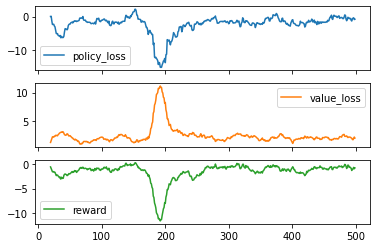

In [17]:
pd.DataFrame(episodes[8])[['policy_loss', 'value_loss', 'reward']].rolling(20).mean().plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

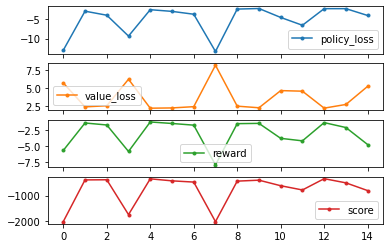

In [10]:
pd.DataFrame([pd.DataFrame(episodes[episode])[['policy_loss', 'value_loss', 'reward',"score"]].mean() for episode in episodes]).plot(subplots=True,
                                                                                                                                    style=".-")

In [ ]:

# reconnect
try:
    env.disconnect()
except:
    None
# Init environment
env = Environment("#", ACT_GRANULARITY)
env.start_sim()
time.sleep(2)
#init variables
state = env.get_state()
score = 0
I = 1

for i in tqdm(range(MAX_STEPS)):

    #get action and log probability
    action, lp = select_action(policy_network, state)

    #step with action
    new_state, reward, done = env.step(action)
    
    #update episode score
    #score += reward

    #get state value of current state
    state_tensor = torch.from_numpy(state).float().to(DEVICE)
    state_val = stateval_network(state_tensor)

    #get state value of next state
    new_state_tensor = torch.from_numpy(new_state).float().to(DEVICE)  
    new_state_val = stateval_network(new_state_tensor)

    #if terminal state, next state val is 0
    #if done:
    #    new_state_val = torch.tensor([0]).float().to(DEVICE)

    #calculate value function loss with MSE
    #val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
    val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val) 
    val_loss *= I

    #calculate policy loss
    advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
    policy_loss = -lp * advantage
    policy_loss *= I
    
    #Backpropagate policy
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()
    #Backpropagate value
    stateval_optimizer.zero_grad()
    val_loss.backward(retain_graph=False)
    stateval_optimizer.step()

    
    run["policy_loss"] += [policy_loss.item()]
    run["value_loss"] += [val_loss.item()]
    run["reward"] += [reward.item()]
    run["states"] += [state]
    run["actions"] += [action]
    run["next_state"] += [new_state]

    #move into new state, discount I
    state = new_state
    I *= DISCOUNT_FACTOR


In [22]:
pd.DataFrame(run)[['policy_loss', 'value_loss', 'reward']].plot(subplots=True)

NameError: name 'run' is not defined

In [23]:
episodes = dict()

#run episodes
for episode in tqdm(range(NUM_EPISODES)):
    # prepare container
    episodes[episode] = dict()
    episodes[episode]["policy_loss"] = []
    episodes[episode]["value_loss"] = []
    episodes[episode]["reward"] = []
    episodes[episode]["states"] = []
    episodes[episode]["actions"] = []
    episodes[episode]["next_state"] = []
    episodes[episode]["grad_policy"] = []
    episodes[episode]["grad_value"] = []
    #init variables
    state = env.reset()
    if state is None:
        state = env.get_state()
    done = False
    score = 0
    I = 1
    
    #run episode, update online
    while True:
        #get action and log probability
        action, lp = select_action(policy_network, state)

        #step with action
        new_state, reward, done = env.step(action)

        #update episode score
        score += reward

        #get state value of current state
        state_tensor = torch.from_numpy(state).float().to(DEVICE)
        state_val = stateval_network(state_tensor)

        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().to(DEVICE)  
        new_state_val = stateval_network(new_state_tensor)

        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().to(DEVICE)

        #calculate value function loss with MSE
        #val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= I

        #calculate policy loss
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp * advantage
        policy_loss *= I

        #Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()

        #Backpropagate value
        stateval_optimizer.zero_grad()
        val_loss.backward(retain_graph=False)
        stateval_optimizer.step()
        
        episodes[episode]["policy_loss"] += [policy_loss.item()]
        episodes[episode]["value_loss"] += [val_loss.item()]
        episodes[episode]["reward"] += [reward.item()]
        episodes[episode]["states"] += [state]
        episodes[episode]["actions"] += [action]
        episodes[episode]["next_state"] += [new_state]
        episodes[episode]["grad_policy"] += [policy_network.output_layer.weight.grad.sum()]
        episodes[episode]["grad_value"] += [stateval_network.output_layer.weight.grad.sum()]
        if done:
            break
        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Connected to remote API server: client id 0


/tmp/ipykernel_611811/2518850387.py:58: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
  1%|▍                                     | 1/100 [29:01<47:52:40, 1741.01s/it]

Connected to remote API server: client id 0
Fail - Attempt 0
Connected to remote API server: client id 0


  1%|▍                                     | 1/100 [39:57<65:56:02, 2397.60s/it]


KeyboardInterrupt: 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

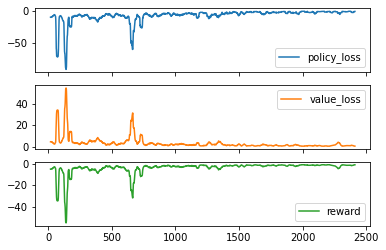

In [24]:
pd.DataFrame(episodes[0])[['policy_loss', 'value_loss', 'reward']].rolling(20).mean().plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

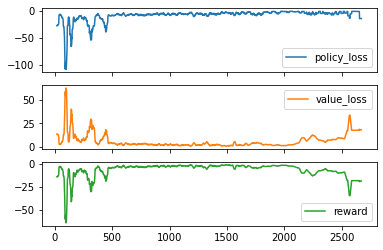

In [22]:
pd.DataFrame(episodes[0])[['policy_loss', 'value_loss', 'reward']].rolling(20).mean().plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

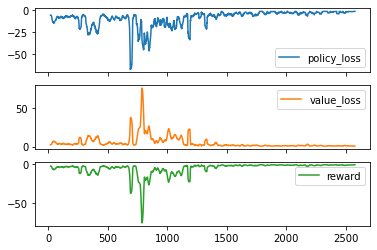

In [21]:
pd.DataFrame(episodes[1])[['policy_loss', 'value_loss', 'reward']].rolling(20).mean().plot(subplots=True)

In [27]:
stateval_network.input_layer.weight.grad.sum()

tensor(627.1545)

In [28]:
policy_network.output_layer.weight.grad.sum()

tensor(0.)

In [11]:
#init variables
state = env.reset()
if state is None:
    state = env.get_state()
done = False
score = 0
I = 1
pls, vls, rws = [], [], []
#run episode, update online
while 1+1 == 2:

    #get action and log probability
    action, lp = select_action(policy_network, state)

    #step with action
    new_state, reward, done = env.step(action)

    #update episode score
    score += reward

    #get state value of current state
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    state_val = stateval_network(state_tensor)

    #get state value of next state
    new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
    new_state_val = stateval_network(new_state_tensor)

    #if terminal state, next state val is 0
    if done:
        new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)

    #calculate value function loss with MSE
    val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
    val_loss *= I

    #calculate policy loss
    advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
    policy_loss = -lp * advantage
    policy_loss *= I

    #Backpropagate policy
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    #Backpropagate value
    stateval_optimizer.zero_grad()
    val_loss.backward()
    stateval_optimizer.step()

    if done:
        break

    #move into new state, discount I
    state = new_state
    I *= DISCOUNT_FACTOR
    print(state[0], "--> ", action)
    pls.append(policy_loss.item())
    vls.append(val_loss.item())
    rws.append(reward.item())

[0.01604992 0.47376559 0.01564194 0.         0.         0.
 0.         0.        ] -->  1
[0.         0.         0.         0.27035554 0.43466926 0.50687068
 0.43606044 0.27161222] -->  0
[0.08284761 0.52791824 0.08562889 0.         0.         0.
 0.         0.        ] -->  1
[1.51482654 1.66057954 1.51593974 0.         0.         0.
 0.         0.        ] -->  1
[1.51570233 1.6605822  1.51559648 0.         0.         0.
 0.         0.        ] -->  1
[0.         0.07492463 0.         0.         0.         0.
 0.         0.        ] -->  0
[1.5120895  1.65799437 1.51342082 0.         0.         0.
 0.         0.        ] -->  1
[1.51907961 1.66007543 1.51293388 0.         0.         0.
 0.         0.        ] -->  1
[1.52306073 1.65969285 1.50952326 0.         0.         0.
 0.         0.        ] -->  1


KeyboardInterrupt: 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

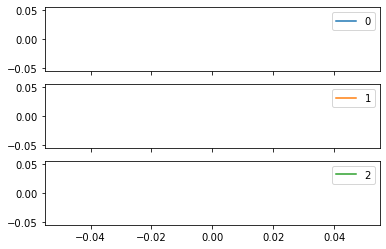

In [15]:
pd.DataFrame([pls, vls, rws]).T.rolling(10).mean().plot(subplots=True)

In [16]:
policy_network.output_layer.weight.grad

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

In [28]:
policy_network.output_layer.weight.grad

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen = 10_000)

#run episodes
for episode in tqdm(range(NUM_EPISODES)):
    
    #init variables
    state = env.reset()
    if state is None:
        state = env.get_state()
    done = False
    score = 0
    I = 1
    
    #run episode, update online
    while 1+1 == 2:
        
        #get action and log probability
        action, lp = select_action(policy_network, state)
        
        #step with action
        new_state, reward, done = env.step(action)
        
        #update episode score
        score += reward
        
        #get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_val = stateval_network(state_tensor)
        
        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
        new_state_val = stateval_network(new_state_tensor)
        
        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
        
        #calculate value function loss with MSE
        val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= I
        
        #calculate policy loss
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp * advantage
        policy_loss *= I
        
        #Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        #Backpropagate value
        stateval_optimizer.zero_grad()
        val_loss.backward()
        stateval_optimizer.step()
        
        if done:
            break
            
        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR
    
    #append episode score 
    scores.append(score)
    recent_scores.append(score)

  0%|                                                   | 0/500 [00:00<?, ?it/s]

Fail - Attempt 0
Connected to remote API server: client id 0


/tmp/ipykernel_403537/594170451.py:43: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
  0%|                                         | 1/500 [01:09<9:40:39, 69.82s/it]

Fail - Attempt 1
Connected to remote API server: client id 0


  0%|▏                                        | 2/500 [02:21<9:50:09, 71.10s/it]

Fail - Attempt 2
Connected to remote API server: client id 0


  0%|▏                                       | 2/500 [02:56<12:10:51, 88.06s/it]


KeyboardInterrupt: 

<AxesSubplot:>

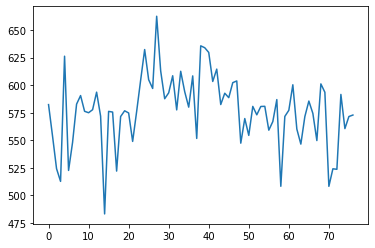

In [15]:
pd.Series(scores).plot()

In [ ]:
#init variables
state = env.reset()
if state is None:
    state = env.get_state()
done = False
score = 0
I = 1
pls, vls, rws = [], [], []

In [ ]:

#run episode, update online
#get action and log probability
action, lp = select_action(policy_network, state)

#step with action
new_state, reward, done = env.step(action)

#update episode score
score += reward

#get state value of current state
state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
state_val = stateval_network(state_tensor)

#get state value of next state
new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
new_state_val = stateval_network(new_state_tensor)

#if terminal state, next state val is 0
if done:
    new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)

#calculate value function loss with MSE
val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
val_loss *= I

#calculate policy loss
advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
policy_loss = -lp * advantage
policy_loss *= I

#Backpropagate policy
policy_optimizer.zero_grad()
policy_loss.backward(retain_graph=True)
policy_optimizer.step()

#Backpropagate value
stateval_optimizer.zero_grad()
val_loss.backward()
stateval_optimizer.step()

if done:
    break

#move into new state, discount I
state = new_state
I *= DISCOUNT_FACTOR

pls.append(policy_loss.item())
vls.append(val_loss.item())
rws.append(reward.item())